In [25]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q langchain
!pip install -q einops
!pip install -q -U wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
^C
ERROR: Operation cancelle

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch

import transformers

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import TrainingArguments

from peft import LoraConfig, get_pet_model, prepare_for_intk_training

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from langchain.prompts import PromptTemplate

from IPython.display import Markdown, display


2023-07-16 14:03:48.232697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 14:03:48.995726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compil

In [2]:
import wandb
api_key = "894fc801a85dc79ac36d24f3f2ac70cebe580ecf"
wandb.login(key=api_key)

wandb: WARNING Path /wandb/ wasn't writable, using system temp directory.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Path /wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /wandb/ wasn't writable, using system temp directory
wandb: Currently logged in as: seshurajup (model-masters). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/healthpulse/.netrc


True

In [3]:
os.environ["WANDB_PROJECT"] = "llm"
data = load_dataset("csv", data_files="/datadrive1/input/wikipedia-stem-1k/stem_1k_v1.csv")
data

Found cached dataset csv (/home/healthpulse/.cache/huggingface/datasets/csv/default-574bb77c03e0b31b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer'],
        num_rows: 1000
    })
})

In [4]:
template = """Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: {prompt}\n
A) {a}\n
B) {b}\n
C) {c}\n
D) {d}\n
E) {e}\n

Answer: {answer}"""

prompt = PromptTemplate(template=template, input_variables=['prompt', 'a', 'b', 'c', 'd', 'e', 'answer'])

In [5]:
sample = data['train'][0]
display(Markdown(prompt.format(prompt=sample['prompt'], 
                               a=sample['A'], 
                               b=sample['B'], 
                               c=sample['C'], 
                               d=sample['D'], 
                               e=sample['E'], 
                               answer=sample['answer'])))

Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: Who is the dean of the University of Central Florida College of Engineering and Computer Science?

A) John Doe

B) Michael Georgiopoulos

C) Jane Smith

D) Robert Johnson

E) David Brown


Answer: B

In [6]:
def format_text(example):
    text = prompt.format(prompt=example['prompt'], 
                         a=example['A'], 
                         b=example['B'], 
                         c=example['C'], 
                         d=example['D'], 
                         e=example['E'], 
                         answer=example['answer'])
    return {"text": text}

In [7]:
data = data.map(format_text)
data

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'text'],
        num_rows: 1000
    })
})

In [8]:
def plot_sequence_lengths(data, split='train', max_length=2048):
    sequence_lengths = []
    keep_indices = []

    # Loop over the dataset and get the lengths of text sequences
    for i, example in enumerate(data[split]):
        sequence_lengths.append(len(example['text']))
        if sequence_lengths[i] < max_length:
            keep_indices.append(i)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return keep_indices

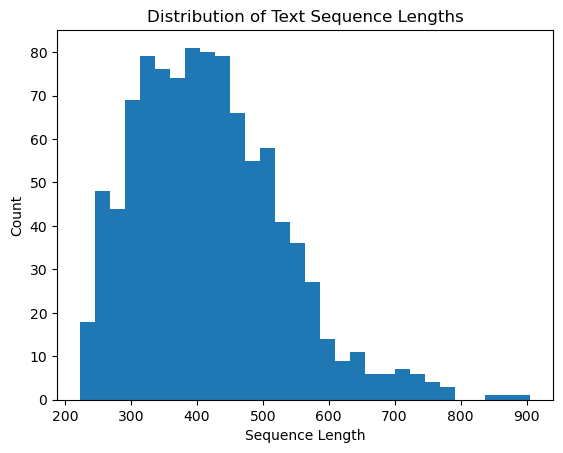

In [9]:
keep_indices_train = plot_sequence_lengths(data)

In [10]:
data['train'] = data['train'].select(keep_indices_train)

In [28]:
model_id = "Salesforce/xgen-7b-4k-base"

In [32]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

A new version of the following files was downloaded from https://huggingface.co/Salesforce/xgen-7b-4k-base:
- tokenization_xgen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


In [33]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    load_in_4bit=True,
    torch_dtype=torch.float16,
    device_map="auto"
    # quantization_config=bnb_config,
    # trust_remote_code=True,
    #revision="2f5c3cd4eace6be6c0f12981f377fb35e5bf6ee5" # Using this version because running the new version gives error 
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
! pip uninstall -y peft

! pip install -U git+https://github.com/huggingface/peft.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: peft 0.4.0.dev0
Uninstalling peft-0.4.0.dev0:
  Successfully uninstalled peft-0.4.0.dev0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-rmxb6d1g
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-rmxb6d1g
  Resolved https://github.com/huggingface/peft.git to commit 42ab10699bcb9fa5e1092373959995930a170f43
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peft: filename=peft-0.4.0.dev0-py3-none-any.whl size=72137 sha256=cd3dfd0b60afd3c6670925a32426b6f

In [1]:
import peft
peft.__version__

2023-07-16 14:49:26.404276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 14:49:27.152044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compil

'0.4.0.dev0'

In [44]:
from peft import LoraConfig, get_peft_model
#prepare_for_int8_training

In [46]:
from peft import prepare_model_for_kbit_training

In [ ]:
model.resize_token_embeddings(len(tokenizer))

In [47]:
model = prepare_model_for_kbit_training(model)

In [49]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    #target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

In [50]:
training_args = TrainingArguments(
    output_dir="/datadrive1/train_models/xgen-4k", 
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    logging_steps=20,
    logging_strategy="steps",
    max_steps=1000,
    optim="paged_adamw_8bit",
    fp16=True,
    run_name="baseline-falcon-sft",
    warmup_ratio=0.1,
    save_strategy="epoch"
)

In [51]:


# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

In [52]:
# base_model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     quantization_config=bnb_config,
#     trust_remote_code=True,
#     #revision="2f5c3cd4eace6be6c0f12981f377fb35e5bf6ee5" # Using this version because running the new version gives error 
# )

In [54]:
supervised_finetuning_trainer = SFTTrainer(
    model,
    train_dataset=data["train"],
    args=training_args,
    tokenizer=tokenizer,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=2048,
    #packing=True,
    data_collator=DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, 
                                                  response_template="Answer:")
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [55]:
%cd /datadrive1/

/datadrive1


In [56]:
! rm -rf train_models/runs/*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
supervised_finetuning_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
20,1.930800
40,1.566300
60,1.448300


KeyboardInterrupt: 